In [1]:
library(lmtest)
library(nlme)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




# Часть 1

In [2]:
generate_regression <- function(x, a, b, lambda){
    
    y <- rep(1,length(x))
    sigma <- rep(1,length(x))
    
    for (i in 2:length(x)){
        sigma[i] <- lambda * sigma[i-1] +  rnorm(1, mean = 0, sd = 1)
    }
    
    for (i in 1:length(x)){
        y[i] <- a + b * x[i] + sigma[i]
    }

    return ( y )
}


# generate_regression_ar1 <- function(x, a, b, lambda) {
#   n <- length(x)
#   epsilon <- rep(0, n)
  
#   for (i in 2:n) {
#     epsilon[i] <- lambda * epsilon[i - 1] + rnorm(1, mean = 0, sd = 1)
#   }

#   y <- a + b * x + epsilon

#   return(list(y = y, epsilon = epsilon))
# }

## Генерация выборки с корреляцией

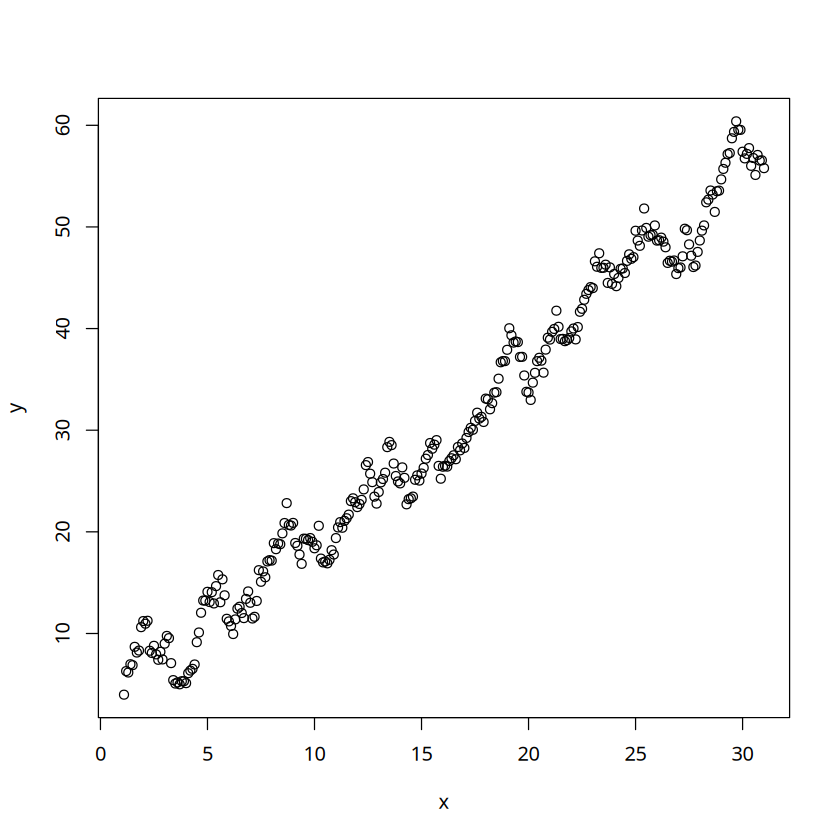

In [3]:
n <- 300
i <- 1:n
x <- 1 + 0.1 * i
y <- generate_regression(x, 1, 1.8, .9)
plot(x, y, type = "p") 

### тест Дарбина-Уотсона 

In [4]:
residuals <- lm(y~x)$residuals

n <- length(residuals)
sum_squared_diff <- sum(diff(residuals)^2)
sum_squared_residuals <- sum(residuals^2)
durbin_watson_statistic <- sum_squared_diff / sum_squared_residuals
durbin_watson_statistic

[1] 0.2098292

Проверю значение библиотечным тестом

In [5]:
dwtest(lm(y~x))


	Durbin-Watson test

data:  lm(y ~ x)
DW = 0.20983, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0


### ДОМНК 

In [6]:
G <- diag(1,n)

X <- cbind(1, x)
teta <- solve(t(X)  %*% solve(G) %*% X) %*% t(X) %*% solve(G) %*% y
teta

# y_pred <- X %*% teta
# residuals <- y - y_pred

,1.893444
x,1.765546


**Вроде все правильно**

In [7]:
gls(y ~ x, correlation = corAR1())

Generalized least squares fit by REML
  Model: y ~ x 
  Data: NULL 
  Log-restricted-likelihood: -452.1372

Coefficients:
(Intercept)           x 
   1.961989    1.759973 

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9050534 
Degrees of freedom: 300 total; 298 residual
Residual standard error: 2.558449 

## Гетероскедастичность

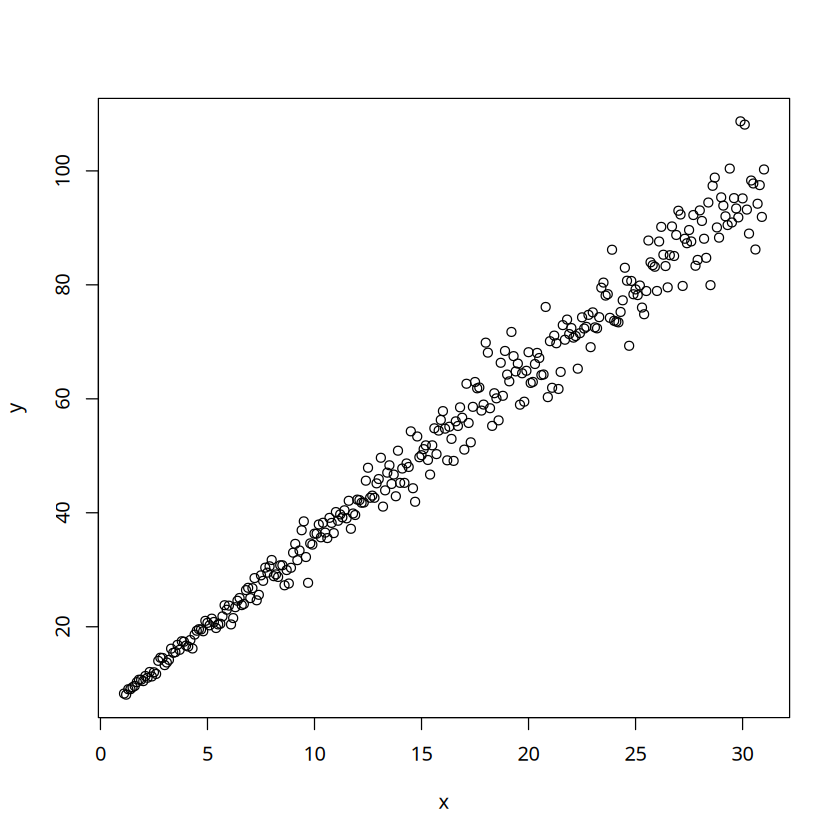

In [8]:
e <- x*rnorm(n,0,.2)
y <- 5+3*x+e
plot(y~x)

In [9]:
model <- summary(lm(y~x))

In [10]:
gqtest(model)


	Goldfeld-Quandt test

data:  model
GQ = 4.9391, df1 = 148, df2 = 148, p-value < 2.2e-16
alternative hypothesis: variance increases from segment 1 to 2


### ОМНК

In [11]:
G <- diag(c(x^2),n)

x0 = rep(1,n)
Y = matrix(c(y),n,1)
X = matrix(c(x0,x),n,2)

teta <- solve(t(X)%*%solve(G)%*%X)%*%t(X)%*%solve(G)%*%Y
teta

4.877596
3.026353


# Часть 2


Call:
lm(formula = Rent ~ M2, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-12529.4  -1374.1   -381.2    432.1  11110.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7391.8     1335.5   5.535 1.28e-06 ***
M2             165.9       42.2   3.931 0.000271 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3474 on 48 degrees of freedom
Multiple R-squared:  0.2435,	Adjusted R-squared:  0.2278 
F-statistic: 15.45 on 1 and 48 DF,  p-value: 0.0002708


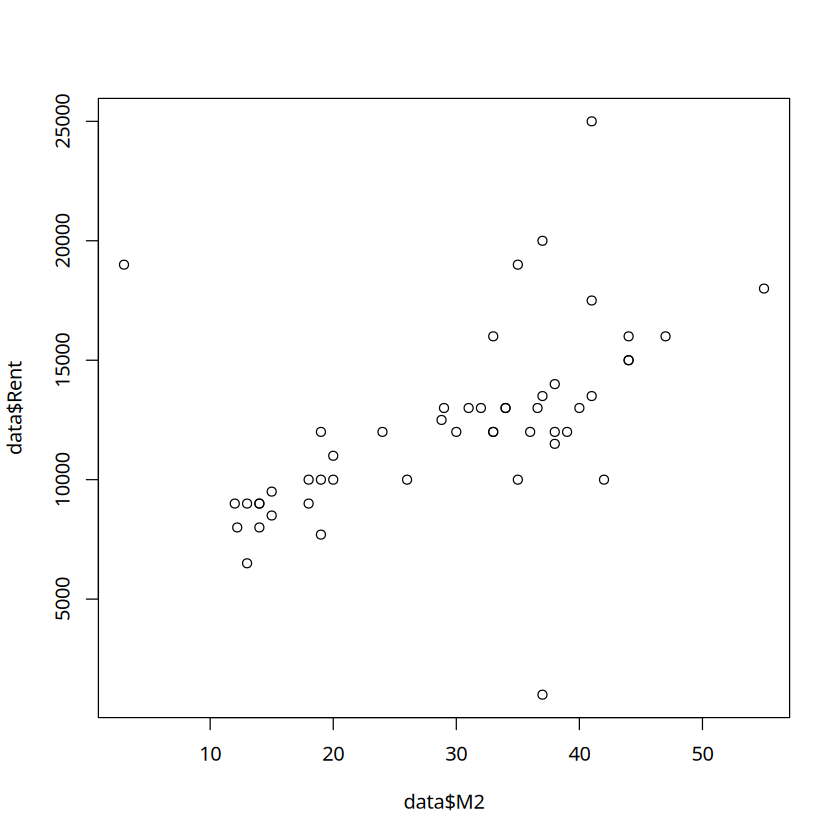

In [12]:
data <- read.table(file = "../Data/flats_1.txt", header = TRUE)
model <- lm(Rent ~ M2, data = data)
plot(data$M2  , data$Rent)
summary(model)

In [13]:
max(data$M2)

[1] 55

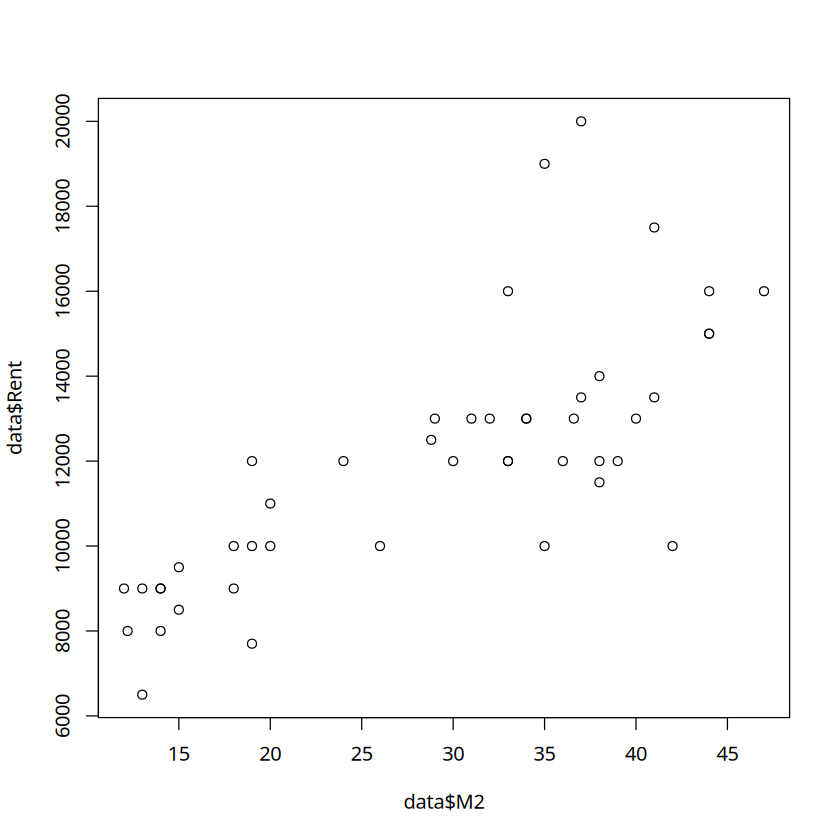

In [14]:
data <- data[-which(data$M2 == 3.0),]
data <- data[-which(data$M2 == 55),] # В регрессию укладывается, но у меня тесты не сходятся. Пробую убрать.
data <- data[-which(data$Rent == 25000),]
data <- data[-which(data$Rent == 1000),]
plot(data$M2  , data$Rent)

In [15]:
model <- lm(Rent ~ M2, data = data)
shapiro.test(model$residuals)


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.89181, p-value = 0.0004602


In [16]:
gqtest(model)


	Goldfeld-Quandt test

data:  model
GQ = 1.6159, df1 = 21, df2 = 21, p-value = 0.1398
alternative hypothesis: variance increases from segment 1 to 2


Присутствует **гетероскедастичность**

In [17]:
dwtest(model)


	Durbin-Watson test

data:  model
DW = 1.5726, p-value = 0.05569
alternative hypothesis: true autocorrelation is greater than 0


```
y = data$Price / data$M2
x = 1/data$M2
```


Call:
lm(formula = y ~ x, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-150.574  -30.365   -2.806   24.005  168.703 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   220.85      22.43   9.847 1.07e-12 ***
x            5586.35     495.84  11.266 1.49e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 63.7 on 44 degrees of freedom
Multiple R-squared:  0.7426,	Adjusted R-squared:  0.7367 
F-statistic: 126.9 on 1 and 44 DF,  p-value: 1.489e-14


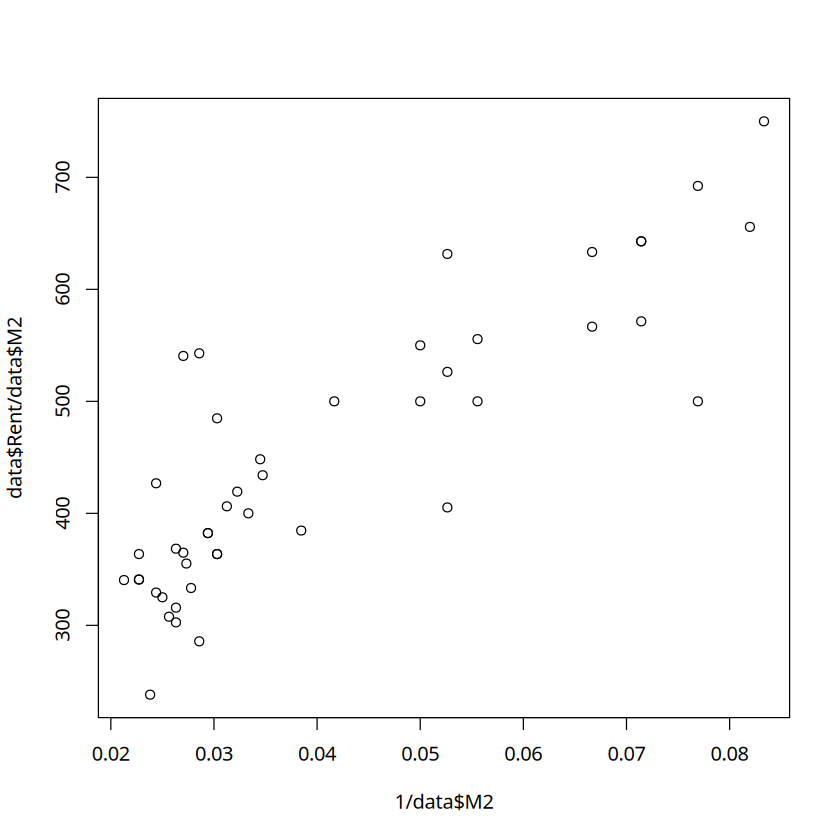

In [18]:
data <- data[ order(data$Rent), ]

y <- data$Rent / data$M2
x <- 1 / data$M2

model2 <- lm( y ~ x ,data = data)
summary(model2)
plot(1/data$M2  , data$Rent/data$M2)

In [19]:
shapiro.test(model2$residuals)


	Shapiro-Wilk normality test

data:  model2$residuals
W = 0.96232, p-value = 0.1411


In [20]:
gqtest(model2)


	Goldfeld-Quandt test

data:  model2
GQ = 0.82998, df1 = 21, df2 = 21, p-value = 0.6634
alternative hypothesis: variance increases from segment 1 to 2


In [21]:
y_head <-( head(data$Rent,30) / head(data$M2,30) )
x_head <- ( 1 / head(data$M2,30 ) )

y_tail <-( tail(data$Rent,30) / tail(data$M2,30) )
x_tail <- ( 1 / tail(data$M2,30) )


model2_head <- lm( y_head ~ x_head )
model2_tail <- lm( y_tail ~ x_tail )
F <- var(model2_head$residuals) / var(model2_tail$residuals)
F

[1] 0.9617702

In [22]:
alpha <- 0.05

# DF1 <- 1
# DF2 <- 59

DF1 <- 21
DF2 <- 21

critical_value <- qf(1 - alpha, DF1, DF2)
critical_value

[1] 2.084189